## 필요 라이브러리 호출

In [78]:
import numpy as np
import operator
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
CIFAR_DATASETS_PATH = "./cifar-10-batches-py/"

In [80]:
# CIFAR-10 Data 위치 찾음
fileList = []
for file in os.listdir(CIFAR_DATASETS_PATH):
    fileList.append(CIFAR_DATASETS_PATH + file)


# 0 -> label
# 1:5 -> Train Set
# 7 -> Test Set
LabelData = fileList[0]
TrainDatasets = fileList[1:5]
TestDatasets = fileList[7]
print(LabelData)
print(TrainDatasets)
print(TestDatasets)

./cifar-10-batches-py/batches.meta
['./cifar-10-batches-py/data_batch_1', './cifar-10-batches-py/data_batch_2', './cifar-10-batches-py/data_batch_3', './cifar-10-batches-py/data_batch_4']
./cifar-10-batches-py/test_batch


# Helper Functions
필요한 함수들

In [81]:
def load_data(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data


def load_multiple_data(fileList):
    X, Y = [], []
    for file in fileList:
        data = load_data(file)
        X.append(data[b'data'])
        Y.append(data[b'labels'])
    return np.concatenate(X), np.concatenate(Y)

labels = load_data(LabelData)[b'label_names']
def get_object(number):
    global labels
    return labels[int(number)]

def view_img(X):
    '''
    input
        X  : 3072 x 1 Array
    '''
    plt.imshow(X.reshape(3,32,32).transpose(1,2,0))

In [82]:
Xtr, Ytr = load_multiple_data(TrainDatasets)
Xte, Yte = load_multiple_data([TestDatasets])
## 형태 확인
print(Xtr.shape, Ytr.shape, Xte.shape, Yte.shape)

(40000, 3072) (40000,) (10000, 3072) (10000,)


b'ship'

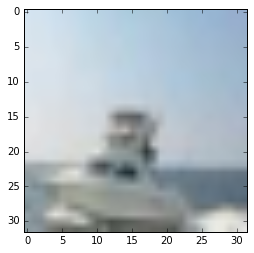

In [83]:
## sample 이미지 확인
i = 100 # 이미지 확인해볼 index
view_img(Xtr[i])
get_object(Ytr[i])

## Nearest Neighbor 클래스 define

In [84]:
class NearestNeighbor(object):
    def train(self, X, Y):
        self.Xtr = X
        self.Ytr = Y
        
        
    def predict(self, X, k=1):
        """
        input:
            X  : N x 3072 shaped numpy array where N indicates the number of images to predict
            k   : when k > 1, knn
            
        return:
            Ypred  : N x 1 numpy array and its element is an integer varying from 0 to 9
        """
        how_many_to_predict = X.shape[0]
        
        Y_pred = np.ones(X.shape[0]) * -1 # create an array length of N (-1 for nothing)
        
        for i in range(how_many_to_predict):
            distances = np.sum(np.abs(X[i, :] - self.Xtr), axis = 1)
            list_with_labels = []
            for label, dist in zip(self.Ytr, distances):
                list_with_labels.append((label, dist))
            list_with_labels = sorted(list_with_labels, key=operator.itemgetter(1))

            if k == 1: # 1- Nearest Neighbor
                Y_pred[i] = list_with_labels[0][0]
            
            else: # K > 1
                possible_results = list_with_labels[:k]
                result_sets  = {}
                for label, dist in possible_results:
                    if label in result_sets.keys():
                        result_sets[label] += 1
                    else:
                        result_sets[label] = 1
                        
                result_sets = sorted(result_sets.items(), key=operator.itemgetter(1))
                Y_pred[i] = result_sets[-1][0]
                        
        return Y_pred

#### Accuracy Test Function

In [85]:
def Accuracy(Y_pred, Y_real):
    acc = np.mean(Y_pred == Y_real)
    print("Accuracy: {:.1f}%".format(acc * 100.0))

In [86]:
nn = NearestNeighbor()
nn.train(Xtr, Ytr)

## Test Data 10000개는 너무 오래걸려서 샘플로 테스트

In [87]:
randomChoices = np.random.choice(range(Xte.shape[0]), size = 5, replace=False)

In [88]:
y_pred = nn.predict(Xte[randomChoices])
y_real = Yte[randomChoices]
for y1, y2 in zip(y_pred, y_real):
    print("Predicted: {} \t\t\t Real: {}".format(get_object(y1), get_object(y2)))
Accuracy(y_pred, y_real)

Predicted: b'airplane' 			 Real: b'airplane'
Predicted: b'cat' 			 Real: b'horse'
Predicted: b'horse' 			 Real: b'truck'
Predicted: b'bird' 			 Real: b'deer'
Predicted: b'airplane' 			 Real: b'airplane'
Accuracy: 40.0%


## KNN when K > 1  

In [89]:
y_pred = nn.predict(Xte[randomChoices], k=5)
y_real = Yte[randomChoices]
for y1, y2 in zip(y_pred, y_real):
    print("Predicted: {} \t\t\t Real: {}".format(get_object(y1), get_object(y2)))
Accuracy(y_pred, y_real)

Predicted: b'airplane' 			 Real: b'airplane'
Predicted: b'frog' 			 Real: b'horse'
Predicted: b'horse' 			 Real: b'truck'
Predicted: b'bird' 			 Real: b'deer'
Predicted: b'airplane' 			 Real: b'airplane'
Accuracy: 40.0%


## Train Set에 대한 검증

#### K = 1 일때

In [90]:
randomChoices = np.random.choice(range(Xtr.shape[0]), size = 5, replace=False)

In [91]:
y_pred = nn.predict(Xtr[randomChoices], k=1)
y_real = Ytr[randomChoices]
for y1, y2 in zip(y_pred, y_real):
    print("Predicted: {} \t\t Real: {}".format(get_object(y1), get_object(y2)))
Accuracy(y_pred, y_real) # 항상 100%가 나와야 함

Predicted: b'airplane' 		 Real: b'airplane'
Predicted: b'horse' 		 Real: b'horse'
Predicted: b'frog' 		 Real: b'frog'
Predicted: b'ship' 		 Real: b'ship'
Predicted: b'airplane' 		 Real: b'airplane'
Accuracy: 100.0%


#### K = 5 일 때

In [92]:
y_pred = nn.predict(Xtr[randomChoices], k=100)
y_real = Ytr[randomChoices]
for y1, y2 in zip(y_pred, y_real):
    print("Predicted: {} \t\t Real: {}".format(get_object(y1), get_object(y2)))
Accuracy(y_pred, y_real)

Predicted: b'ship' 		 Real: b'airplane'
Predicted: b'cat' 		 Real: b'horse'
Predicted: b'frog' 		 Real: b'frog'
Predicted: b'ship' 		 Real: b'ship'
Predicted: b'bird' 		 Real: b'airplane'
Accuracy: 40.0%
